In [26]:
%matplotlib inline
import collections
import dask
import gcsfs
import h5py
import io
import matplotlib.pyplot as plt
import numpy as np
import numba
from numba.typed import Dict, List
import pickle


from dask.distributed import Client
from dask_kubernetes import KubeCluster
from numba.typed import Dict
dendrites = h5py.File('../cache/dendrites.hdf5', 'r')
axons = h5py.File('../cache/axons.hdf5', 'r')

In [42]:
cluster = KubeCluster.from_yaml('worker-spec-big.yml')
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.36.0.171:43207
distributed.scheduler - INFO -   dashboard at:                     :8787


In [41]:
cluster.close()

distributed.scheduler - INFO - Scheduler closing...
distributed.scheduler - INFO - Scheduler closing all comms


In [43]:
client = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-5a949d3a-4c21-11ea-80a3-fed3d61200dd
distributed.core - INFO - Starting established connection


Draw a thick 3d line. We will use this to draw axons. Use Bresenham's algorithm to draw a thin 3d line, then thicken it using a queue, similar to a flood fill algorithm (https://en.wikipedia.org/wiki/Flood_fill#Alternative_implementations).

(-17.1, 117.1, -5.5, 5.5)

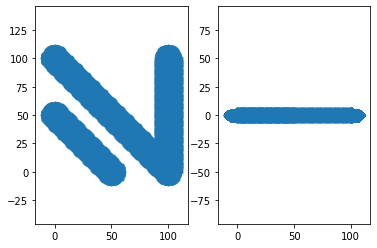

In [2]:
# From https://www.geeksforgeeks.org/bresenhams-algorithm-for-3-d-line-drawing/
def Bresenham3D(x1, y1, z1, x2, y2, z2): 
    ListOfPoints = [] 
    ListOfPoints.append((x1, y1, z1)) 
    dx = abs(x2 - x1) 
    dy = abs(y2 - y1) 
    dz = abs(z2 - z1) 
    if (x2 > x1): 
        xs = 1
    else: 
        xs = -1
    if (y2 > y1): 
        ys = 1
    else: 
        ys = -1
    if (z2 > z1): 
        zs = 1
    else: 
        zs = -1
  
    # Driving axis is X-axis" 
    if (dx >= dy and dx >= dz):         
        p1 = 2 * dy - dx 
        p2 = 2 * dz - dx 
        while (x1 != x2): 
            x1 += xs 
            if (p1 >= 0): 
                y1 += ys 
                p1 -= 2 * dx 
            if (p2 >= 0): 
                z1 += zs 
                p2 -= 2 * dx 
            p1 += 2 * dy 
            p2 += 2 * dz 
            ListOfPoints.append((x1, y1, z1)) 
  
    # Driving axis is Y-axis" 
    elif (dy >= dx and dy >= dz):        
        p1 = 2 * dx - dy 
        p2 = 2 * dz - dy 
        while (y1 != y2): 
            y1 += ys 
            if (p1 >= 0): 
                x1 += xs 
                p1 -= 2 * dy 
            if (p2 >= 0): 
                z1 += zs 
                p2 -= 2 * dy 
            p1 += 2 * dx 
            p2 += 2 * dz 
            ListOfPoints.append((x1, y1, z1)) 
  
    # Driving axis is Z-axis" 
    else:         
        p1 = 2 * dy - dz 
        p2 = 2 * dx - dz 
        while (z1 != z2): 
            z1 += zs 
            if (p1 >= 0): 
                y1 += ys 
                p1 -= 2 * dz 
            if (p2 >= 0): 
                x1 += xs 
                p2 -= 2 * dz 
            p1 += 2 * dy 
            p2 += 2 * dx 
            ListOfPoints.append((x1, y1, z1)) 
    return ListOfPoints 

@numba.jit(nopython=True)
def expand_line(seeds, line_radius, scales):
    queue = list(zip(seeds, [x for x in range(len(seeds))]))
    
    # This weird number is a type hint for numba.
    already_found = {(-1000, -1000, -1000): 1}
    for el in seeds:
        already_found[el] = 1
    
    line_radius2 = line_radius ** 2
    line_vector = (seeds[-1][0] - seeds[0][0], seeds[-1][1] - seeds[0][1], seeds[-1][2] - seeds[0][2])
    
    deltas = ((0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0))
    points = []
    for el, closest_seed in queue:
        points.append(el)
        
        # Consider the 6 neighbors of the elements
        for d in deltas:
            if len(deltas) > 1E6:
                print("Too many points in this neighborhood.")
                return points
            new_el = (el[0] + d[0], el[1] + d[1], el[2] + d[2])
            if new_el in already_found:
                continue
            else:
                # Distance to the ends.
                if closest_seed == 0:
                    rg = [0, 1]
                    slc = slice(0, 2)
                elif closest_seed == len(seeds) - 1:
                    rg = [closest_seed - 1, closest_seed]
                    slc = slice(closest_seed - 1, None)
                else:
                    rg = [closest_seed - 1, closest_seed, closest_seed + 1]
                    slc = slice(closest_seed - 1, closest_seed + 2)
                    
                min_distance, new_closest_seed = min([((scales[0] * (el[0] - x[0])) ** 2 + 
                                                       (scales[1] * (el[1] - x[1])) ** 2 + 
                                                       (scales[2] * (el[2] - x[2])) ** 2, num) for num, x in zip(rg, seeds[slc])])
                
                # Distance to the core
                if min_distance > line_radius2:
                    continue
                
                already_found[new_el] = 1
                queue.append((new_el, new_closest_seed))
    return points

def draw_line(from_, to_, line_radius):
    """Draw a 3d line.
    
    Args:
        from_: a position (length-3 numpy vector)
        to_: a position (length-3 numpy vector)
        line_radius: the radius of the line (half the thickness)
        
    Returns:
        Numpy array of shape (x, 3) with filled in points. """
    seeds = Bresenham3D(from_[0], from_[1], from_[2], to_[0], to_[1], to_[2])
    scales = (1, 1, 2.49)
    return expand_line(seeds, line_radius, scales)

def draw_lines(from_, to_, line_radius):
    """Draw 3d line.
    
    Args:
        from_: positions (N X 3 numpy vector)
        to_: positions (N X 3 numpy vector)
        line_radius: the radius of the line (half the thickness)
        
    Returns:
        Numpy array of shape (x, 3) with filled in points. """
    bag_of_seeds = []
    current_seeds = []
    last_t = (-1000, -1000, -1000)
    for f, t in zip(from_, to_):
        assert len(f) == 3
        assert len(t) == 3
        new_seeds = Bresenham3D(f[0], f[1], f[2], t[0], t[1], t[2])
        if f == last_t:
            current_seeds += new_seeds[2:]
        else:
            bag_of_seeds.append(current_seeds)
            current_seeds = list(new_seeds)
            
        last_t = t
    
    bag_of_seeds.append(current_seeds)
    bag_of_seeds = bag_of_seeds[1:]
    scales = (1, 1, 2.49)
    
    all_pixels = set()
    the_lines = []
    for seeds in bag_of_seeds:
        seeds_typed = List()
        [seeds_typed.append(x) for x in seeds]
    
        pixels = expand_line(seeds_typed, line_radius, scales)
        all_pixels = all_pixels.union(set(pixels))
    return all_pixels

lines = np.array(list(draw_lines([(0, 100, 0), (100, 0, 0), (0, 50, 0)], [(100, 0, 0), (100, 100, 0), (50, 0, 0)], 10)))
plt.subplot(121)
_ = plt.plot(lines[:, 0], lines[:, 1], '.')
plt.axis('equal')
plt.subplot(122)
_ = plt.plot(lines[:, 0], lines[:, 2], '.')
plt.axis('equal')

In [24]:
with open('axon_to_neuron.pkl', 'rb') as f:
    axon_info = pickle.load(f)
    
axon_info.keys()
axons_segments, axon_map, axon_aggs = axon_info['axon_segments'], axon_info['axon_map'], axon_info['axon_aggs']

(4101.05, 5639.95, 7596.7, 7757.3)

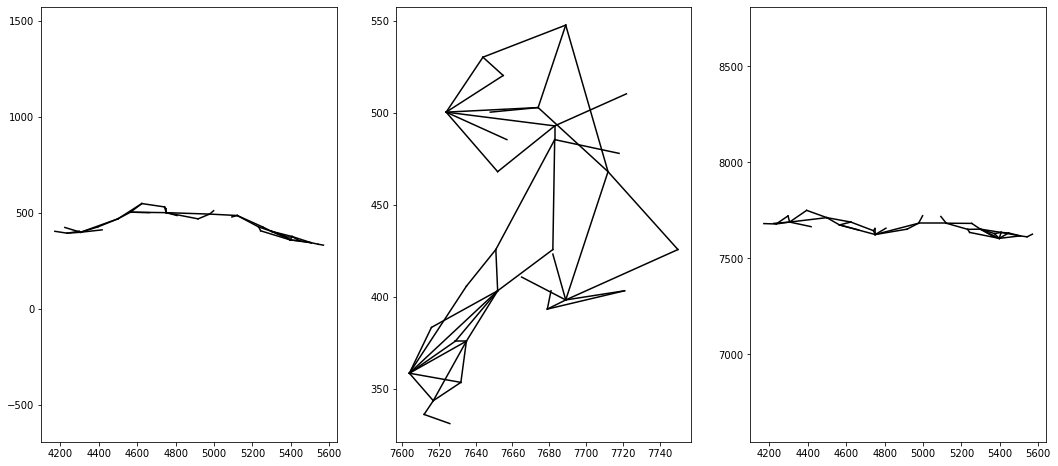

In [30]:
id = 91
axon_agg = axon_aggs[id][0]
just_segments = axons['axons']['agglomerate'][axon_agg]
just_segments

edges = np.array(axons['axons']['skeleton'][axon_agg]['edges']) - 1
nodes = np.array(axons['axons']['skeleton'][axon_agg]['nodes'])
segIds = np.array(axons['axons']['skeleton'][axon_agg]['segIds'])

L = np.concatenate((nodes[:, edges[0, :]], nodes[:, edges[1, :]]), axis=0)
S = np.concatenate((segIds[edges[0, :]].reshape((1, -1)), segIds[edges[1, :]].reshape((1, -1))), axis=0)
badS = np.all(S == 0, axis=0)

plt.figure(figsize=(18, 8))
plt.subplot(131)
_ = plt.plot(L[[0, 3], :][:, ~badS], L[[2, 5], :][:, ~badS] * 2.49, 'k-')
_ = plt.plot(L[[0, 3], :][:, badS], L[[2, 5], :][:, badS] * 2.49, 'r-')
plt.axis('equal')

plt.subplot(132)
_ = plt.plot(L[[1, 4], :][:, ~badS], L[[2, 5], :][:, ~badS] * 2.49, 'k-')
_ = plt.plot(L[[1, 4], :][:, badS], L[[2, 5], :][:, badS] * 2.49, 'r-')
plt.axis('equal')

plt.subplot(133)
_ = plt.plot(L[[0, 3], :][:, ~badS], L[[1, 4], :][:, ~badS], 'k-')
_ = plt.plot(L[[0, 3], :][:, badS], L[[1, 4], :][:, badS], 'r-')
plt.axis('equal')

Adding the information in the skeleton (red) is much better than just the information in the agglomerates (black) for axons. This is because much of the axons in this dataset were manually traced. Therefore, rebuild axons in the dataset using line drawing.

In [7]:
with open('../.gcs_tokens', 'rb') as f:
    credentials = pickle.load(f)
credentials = credentials[list(credentials.keys())[0]]
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)

In [58]:
def draw_one_axon(id, axon_aggs):
    batch_size = 125
    print("Tracing axon of neuron %d" % id)
    from_lines = []
    to_lines = []
    
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    fd = fs.open('l4dense/dendrites.hdf5', 'rb')
    dendrites = h5py.File(fd, 'r')

    fa = fs.open('l4dense/axons.hdf5', 'rb')
    axons = h5py.File(fa, 'r')

    for axon_agg in axon_aggs:
        edges = np.array(axons['axons']['skeleton'][axon_agg]['edges']) - 1
        nodes = np.array(axons['axons']['skeleton'][axon_agg]['nodes'])

        segIds = np.array(axons['axons']['skeleton'][axon_agg]['segIds'])
        S = np.concatenate((segIds[edges[0, :]].reshape((1, -1)), segIds[edges[1, :]].reshape((1, -1))), axis=0)
        badS = np.any(S == 0, axis=0)

        from_ = nodes[:, edges[0, badS]].T.astype(int)
        to_ = nodes[:, edges[1, badS]].T.astype(int)
        from_lines += [tuple(x) for x in from_]
        to_lines += [tuple(x) for x in to_]
        
    fd.close()
    fa.close()

    nbatches = int(np.ceil(len(from_lines) / batch_size))
    for k in range(nbatches):
        rg = slice(k * batch_size, (k + 1) * batch_size)
        pixels = list(draw_lines(from_lines[rg], to_lines[rg], 32))

        out_name = 'l4dense/axon-pixels/n%02d_batch%02d_%02d.pkl' % (id, k, nbatches)
        bio = io.BytesIO()
        pickle.dump(pixels, bio)
        data = bio.getvalue()
        with fs.open(out_name, 'wb') as f:
            f.write(data)
    return 1

#for id in axon_aggs.keys():
#
#n_neurons = 0
#for id in missing_ids:
#    if axon_aggs[id]:
#        n_neurons += draw_one_axon(id, axon_aggs[id])
#        
#n_neurons.compute()
draw_one_axon(74, axon_aggs[74])

Tracing axon of neuron 74


1

In [57]:
axon_aggs[74]

['30048']

In [48]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
missing_ids = []
for id in axon_aggs:
    if axon_aggs[id]:
        found = False
        for i in range(32):
            file = fs.ls('l4dense/axon-pixels/n%02d_batch%02d_%02d.pkl' % (id, i, i+1))
            if len(file) == 1:
                found = True
                break
        print(id, found)
        if not found:
            missing_ids.append(id)

1 True
3 True
4 True
7 False
8 True
10 True
13 True
14 True
19 True
20 True
21 False
22 True
25 True
27 True
29 True
30 True
31 True
32 True
38 True
39 True
40 True
42 True
43 True
49 True
51 False
52 True
53 True
54 True
55 True
60 True
63 True
64 True
66 True
68 True
71 True
74 False
75 False
77 True
79 True
80 True
82 True
83 True
86 True
88 False
89 True
91 False


In [22]:
import logging

def check_complete(id, credentials):
    logger = logging.getLogger(__name__)
    logger.info('Working on %d' % id)
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    found = False
    for i in range(64):
        file = fs.ls('l4dense/axon-pixels/n%02d_batch%02d_%02d.pkl' % (id, i, i+1))
        if len(file) == 1:
            found = True
            break
            
    if not found:
        return 0
    
    nbatches = i + 1
        
    for batch in range(nbatches):
        # Check if we've done this before.
        final_name = 'l4dense/axon-volume-separate/n%02d_batch%02d.final' % (id, batch)
        if not fs.exists(final_name):
            return False
        
    return True

completion = []
for id in axon_aggs.keys():
    completion.append((id, check_complete(id, credentials)))
completion

[1,
 True,
 3,
 True,
 4,
 True,
 7,
 0,
 8,
 True,
 10,
 True,
 13,
 True,
 14,
 True,
 19,
 True,
 20,
 True,
 21,
 True,
 22,
 True,
 25,
 True,
 27,
 True,
 29,
 True,
 30,
 True,
 31,
 True,
 32,
 True,
 38,
 True,
 39,
 True,
 40,
 True,
 42,
 True,
 43,
 True,
 49,
 True,
 51,
 False,
 52,
 True,
 53,
 True,
 54,
 True,
 55,
 True,
 60,
 True,
 63,
 True,
 64,
 True,
 66,
 True,
 68,
 True,
 71,
 True,
 74,
 0,
 75,
 0,
 77,
 True,
 79,
 True,
 80,
 True,
 82,
 True,
 83,
 True,
 86,
 False,
 88,
 False,
 89,
 True,
 91,
 0]

In [ ]:
import logging

@dask.delayed
def chop_and_distribute(id, credentials):
    logger = logging.getLogger(__name__)
    logger.info('Working on %d' % id)
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    found = False
    for i in range(64):
        file = fs.ls('l4dense/axon-pixels/n%02d_batch%02d_%02d.pkl' % (id, i, i+1))
        if len(file) == 1:
            found = True
            break
            
    if not found:
        return 0
    
    nbatches = i + 1
        
    for batch in range(nbatches):
        # Check if we've done this before.
        final_name = 'l4dense/axon-volume-separate/n%02d_batch%02d.final' % (id, batch)
        if fs.exists(final_name):
            continue
            
        xyz = collections.defaultdict(lambda: [])
        file = fs.open('l4dense/axon-pixels/n%02d_batch%02d_%02d.pkl' % (id, batch, nbatches), 'rb')
        the_dat = pickle.load(file)
        logger.info('%d pixels to dump' % len(the_dat))
        
        for pixel in the_dat:
            xx, yy, zz = pixel[0] // 1024, pixel[1] // 1024, pixel[2] // 1024
            if xx < 0 or xx > 5 or yy < 0 or yy > 8 or zz < 0 or zz > 3:
                continue
            xyz[(xx, yy, zz)].append((pixel[0] - xx * 1024, pixel[1] - yy * 1024, pixel[2] - zz * 1024, id))
            
        # Time to write to disk.
        for key, val in xyz.items():
            out_name = 'l4dense/axon-volume-separate/x%dy%dz%d_n%02d_batch%02d.pkl' % (key[0], key[1], key[2], id, batch)
            bio = io.BytesIO()
            pickle.dump(val, bio)
            data = bio.getvalue()
            with fs.open(out_name, 'wb') as f:
                f.write(data)
        
        with fs.open(final_name, 'w') as f:
            f.write("final")
        
    return 1

n_neurons = 0
for id in axon_aggs.keys():
    n_neurons += chop_and_distribute(id, credentials)
n_neurons.compute()